In [54]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [55]:
# from google.colab import drive
# drive.mount('/content/drive')

In [56]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot") # 這行程式碼設置了 matplotlib 的繪圖風格。

# 這是 Jupyter Notebook 的魔法命令，它用於指定 matplotlib 繪圖的輸出方式。
# 可以直接在 Notebook 中看到圖形，而不需要使用 plt.show()。
%matplotlib inline 
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K

from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.image import *
from keras.callbacks import *

from keras.utils import plot_model

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [57]:
w, h = 640, 640
border = 5 

In [58]:
ids = next(os.walk("dataset_copy_3_imgs/train/Images"))[2] # list of names all images in the given path
print(ids)
print("No. of images = ", len(ids))

['2_jpg.rf.60369561fc1520a37e9145f6ecd47916.jpg', '4_jpg.rf.38e454f25bf0b15ff1cf507920b872bd.jpg', '8_jpg.rf.b0df4a218edbe5fb7e0e023f2428d25f.jpg']
No. of images =  3


# **Data Reading and Train test split**

In [59]:
# from google.colab import drive
# drive.mount('/content/drive')

In [60]:
import glob
train = sorted(glob.glob("dataset_copy_3_imgs/train/Images/*"))
train_mask = sorted(glob.glob("dataset_copy_3_imgs/train/Mask/*.jpg"))[:64]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 3
Total Mask Image : 3


In [61]:
X = np.zeros((len(train), h, w, 1), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)
X_name = []

In [62]:
for n, (img, mimg) in (enumerate(zip(train, train_mask))):
  print(n, img, mimg)
  X_name.append(img)

  # Load images
  img = load_img(img, color_mode = "grayscale")
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 1), mode = 'constant', preserve_range = True)

  # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  
  # Save images
  X[n] = x_img/255
  y[n] = mask/255

0 dataset_copy_3_imgs/train/Images\2_jpg.rf.60369561fc1520a37e9145f6ecd47916.jpg dataset_copy_3_imgs/train/Mask\2_jpg.rf.60369561fc1520a37e9145f6ecd47916.jpg
1 dataset_copy_3_imgs/train/Images\4_jpg.rf.38e454f25bf0b15ff1cf507920b872bd.jpg dataset_copy_3_imgs/train/Mask\4_jpg.rf.38e454f25bf0b15ff1cf507920b872bd.jpg
2 dataset_copy_3_imgs/train/Images\8_jpg.rf.b0df4a218edbe5fb7e0e023f2428d25f.jpg dataset_copy_3_imgs/train/Mask\8_jpg.rf.b0df4a218edbe5fb7e0e023f2428d25f.jpg


In [63]:
if not os.path.exists("x_y_npy"):
    os.makedirs("x_y_npy")

# Save the files in Numpy array for reusability
np.save('x_y_npy/x.npy', X)
np.save('x_y_npy/y.npy', y)
print(X.shape, y.shape)
X = np.load('x_y_npy/x.npy')
y = np.load('x_y_npy/y.npy')
print(X.shape, y.shape)
print(X_name)

(3, 640, 640, 1) (3, 640, 640, 1)
(3, 640, 640, 1) (3, 640, 640, 1)
['dataset_copy_3_imgs/train/Images\\2_jpg.rf.60369561fc1520a37e9145f6ecd47916.jpg', 'dataset_copy_3_imgs/train/Images\\4_jpg.rf.38e454f25bf0b15ff1cf507920b872bd.jpg', 'dataset_copy_3_imgs/train/Images\\8_jpg.rf.b0df4a218edbe5fb7e0e023f2428d25f.jpg']


In [64]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect() #  用於清理不再使用的對象，釋放內存。

(2, 640, 640, 1) (2, 640, 640, 1) (1, 640, 640, 1) (1, 640, 640, 1)


23832

# **Visualization the image and It masks**

1. X_train[idx, ..., 0] = X_train[idx, :, :, 0]

2. 現在讓我們解釋一下 squeeze() 的作用。在 NumPy 中，squeeze() 函數用於刪除大小為 1 的維度。在這種情況下，y_train[ix] 的形狀可能是 (640, 640, 1)，其中最後一個維度是 1。squeeze() 的作用是將這個大小為 1 的維度擠壓掉，使得遮罩的形狀變為 (640, 640)，這是 contour 函數期望的形狀。https://steam.oxxostudio.tw/category/python/example/matplotlib-contour.html
3. 它指定輪廓線應該在哪些值處繪製。如果省略此參數，contour 函數將自動選擇一組適合的值。

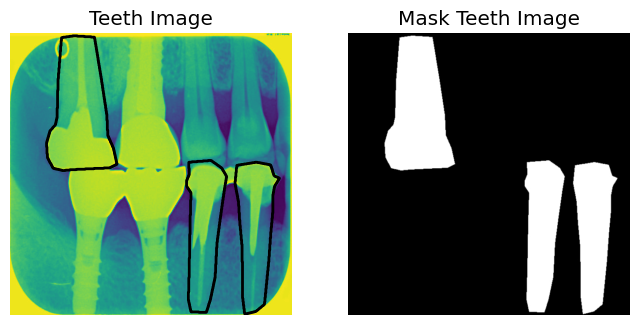

In [65]:
# Visualize any randome image along with the mask
idx = random.randint(0, len(X_train)-1)
has_mask = y_train[idx].max() > 0 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 8))

ax1.imshow(X_train[idx, ..., 0], interpolation = 'bilinear')
if has_mask:
    ax1.contour(y_train[idx].squeeze(), colors = 'k', linewidths = 2, levels = [0.5])
ax1.set_title('Teeth Image')
ax1.set_axis_off() # 不顯示 x, y 軸線

ax2.imshow(y_train[idx].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Teeth Image')
ax2.set_axis_off() # 不顯示 x, y 軸線

## Build DenseUnet

1. `清理 Keras Session` : 這一部分的目的是清理先前 Keras 會話中的任何模型，變數或計算圖。這有助於釋放資源並確保你在定義新模型之前的狀態是乾淨的。
2. `建立模型` : input_shape 參數指定了模型的輸入形狀，nClasses 指定了輸出的標籤數量，這裡是 1，可能是二元分類的情況。
3. `3. 定義評估指標（Metrics）`: 定義了一組評估指標（metrics）包括準確度（accuracy）、AUC、在特定特異度（Specificity）下的敏感度（Sensitivity）和在特定敏感度下的特異度。這些指標將在模型訓練過程中被計算。
4. `編譯模型` : 指定優化器（optimizer）為 Adam，損失函數（loss function）為二元交叉熵（binary_crossentropy），並指定了之前定義的評估指標列表。
5. `清理資源` : 最後一行使用 gc.collect() 進行垃圾回收，釋放不再使用的資源。

In [71]:
from keras import backend as K
from model.DenseUnet import DenseUNet
K.clear_session()

# input_img = Input((h, w, 1), name='img')
# del model
model = DenseUNet(nClasses=1, input_height=h, input_width=w)
gc.collect()

25019

In [72]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 640, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 16)         160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 640, 640, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 640, 640, 16)         0         ['batch_normalization[0][0

* tf.keras.utils.plot_model 函數繪製模型結構。該函數的參數說明如下：
1. `model`: 要繪製的 Keras 模型。
2. `to_file`: 指定保存圖像的文件名。
3. `show_shapes`: 如果為 True，將顯示每個層的輸入/輸出形狀。
4. `show_layer_names`: 如果為 True，將顯示每個層的名稱。
* https://blog.csdn.net/L_cherry_/article/details/122111303

In [68]:
# plot_model(model, to_file='model/DenseUnet.png', show_shapes=True, show_layer_names=True)

* verbose=0：不輸出任何信息。
* verbose=1：輸出一些基本信息，例如進度條等。
* verbose=2：輸出更詳細的信息。
* `TensorBoard` : 開啟 cmd/終端機，執行 tensorboard --logdir=.\logs，啟動網頁伺服器，再使用瀏覽器輸入以下網址，即可觀看訓練資訊：
http://localhost:6006/
* Keras Callback 的使用 : https://ithelp.ithome.com.tw/articles/10234641?sc=pt

In [73]:

callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model/model-DenseUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("result/data_DenseUnet.csv"),
    TensorBoard(log_dir='./logs')
]
# >> tensorboard --logdir=path/to/logs

In [75]:
# 載入最近的檢查點的權重
# model.load_weights('model/model-UnetPP.h5') # change 
results = model.fit(X_train, y_train, batch_size=1, epochs=5, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)


Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node confusion_matrix/assert_less/Assert/AssertGuard/Assert defined at (most recent call last):
  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\runpy.py", line 197, in _run_module_as_main

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\runpy.py", line 87, in _run_code

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\asyncio\base_events.py", line 601, in run_forever

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\asyncio\base_events.py", line 1905, in _run_once

  File "C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 518, in process_one

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\kernelbase.py", line 766, in execute_request

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\user\AppData\Local\Temp\ipykernel_10284\2599320042.py", line 3, in <module>

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 1155, in train_step

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\training.py", line 1249, in compute_metrics

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\engine\compile_utils.py", line 620, in update_state

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn

  File "c:\Users\user\Desktop\Dense-Unet\.venv\lib\site-packages\keras\src\metrics\iou_metrics.py", line 141, in update_state

assertion failed: [`labels` out of bound] [Condition x < y did not hold element-wise:] [x (confusion_matrix/control_dependency:0) = ] [0 0 0...] [y (confusion_matrix/Cast_2:0) = ] [1]
	 [[{{node confusion_matrix/assert_less/Assert/AssertGuard/Assert}}]] [Op:__inference_train_function_164830]

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
0,0.212111,0.902883,0.955883,0.990373,0.984181,0.467714,0.780146,0.772685,0.835308,0.857617,0.001
1,0.186341,0.927113,0.967765,0.994276,0.994436,0.478196,0.773931,0.775603,0.850913,0.856061,0.001
2,0.172860,0.929287,0.971051,0.995062,0.993239,0.484481,0.776545,0.771394,0.829858,0.857924,0.001
3,0.154687,0.935743,0.977107,0.996008,0.996520,0.488999,0.775862,0.766647,0.819714,0.854563,0.001
4,0.143665,0.938173,0.980755,0.996793,0.997400,0.511162,0.762935,0.765378,0.822566,0.857512,0.001


In [ ]:
print(results.history)
print(results.epoch)
print(results.model)

{'loss': [0.2121107280254364, 0.1863410919904709, 0.17285972833633423, 0.15468719601631165, 0.1436653733253479], 'accuracy': [0.9028832912445068, 0.9271130561828613, 0.9292871356010437, 0.9357433915138245, 0.9381725788116455], 'auc': [0.9558834433555603, 0.967765212059021, 0.9710509181022644, 0.9771072864532471, 0.9807549715042114], 'sensitivity_at_specificity': [0.9903729557991028, 0.9942761063575745, 0.9950615167617798, 0.9960075616836548, 0.9967929720878601], 'specificity_at_sensitivity': [0.9841814041137695, 0.9944358468055725, 0.9932394623756409, 0.996519923210144, 0.9973999261856079], 'val_loss': [0.46771439909935, 0.47819629311561584, 0.4844810962677002, 0.48899877071380615, 0.511161744594574], 'val_accuracy': [0.7801464796066284, 0.7739306688308716, 0.7765454053878784, 0.7758617997169495, 0.7629345655441284], 'val_auc': [0.7726846933364868, 0.7756025195121765, 0.7713938355445862, 0.766647458076477, 0.7653779983520508], 'val_sensitivity_at_specificity': [0.8353078961372375, 0.85

* `results.history` : 通常，當你使用 Keras 或 TensorFlow 中的 fit 方法訓練模型時，fit 方法會返回一個 History 物件，其中包含了模型在訓練過程中的各種指標的歷史記錄。

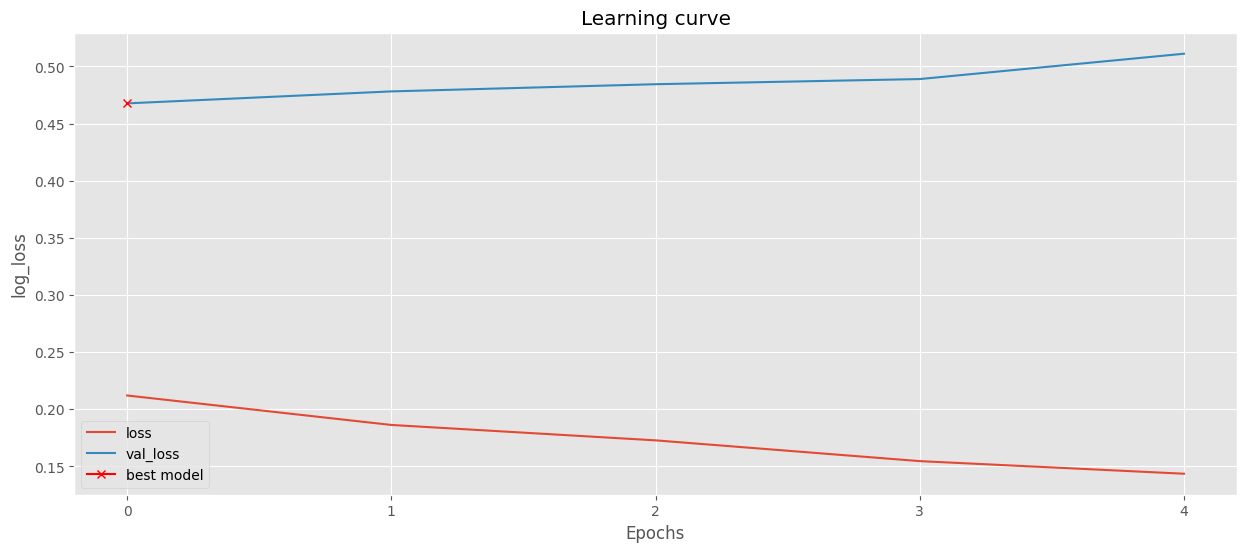

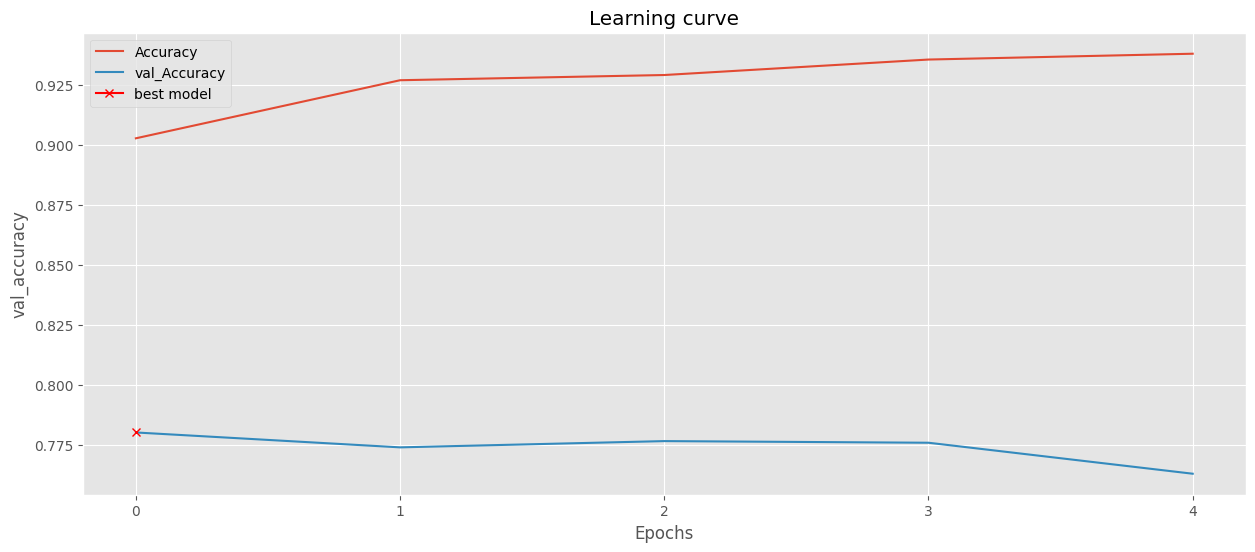

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss") # 畫出訓練集的損失函數，並標示為 "loss"。
plt.plot(results.history["val_loss"], label="val_loss") # 畫出驗證集的損失函數，並標示為 "val_loss"。

## 在最佳驗證損失處標示一個紅色的 "x"，表示最佳模型的位置。
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.xticks(results.epoch)
plt.legend(); # 在圖中添加圖例
plt.savefig('result/log_loss.png')

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")

plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("val_accuracy")
plt.xticks(results.epoch)
plt.legend(); 
plt.savefig('result/val_accuracy.png')

# **Inference**

In [ ]:
model.load_weights('model/model-UnetPP.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)
# model.metrics_names

1/1 [==============================] - 4s 4s/step - loss: 0.4677 - accuracy: 0.7801 - auc: 0.7727 - sensitivity_at_specificity: 0.8353 - specificity_at_sensitivity: 0.8576


[0.46771439909935,
 0.7801464796066284,
 0.7726846933364868,
 0.8353078961372375,
 0.8576167225837708]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 2s 2s/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
print(preds_test.shape)
print(preds_test_t.shape)

(1, 640, 640, 1)
(1, 640, 640, 1)


In [ ]:
from sklearn.metrics import classification_report


In [ ]:
def plot_sample(X, y, preds, binary_preds, idx=None):
    """Function to plot the results"""
    if idx is None:
        idx = random.randint(0, len(X))

    has_mask = y[idx].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10)) # 建立子圖

    # 顯示原圖
    ax[0].imshow(X[idx, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[idx].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Teeth Image')
    ax[0].set_axis_off()

    # 顯示 mask 照片
    ax[1].imshow(y[idx].squeeze(), cmap='gray')
    ax[1].set_title('Teeth Mask Image')
    ax[1].set_axis_off()

    # 顯示預測到的所有物件
    ax[2].imshow(preds[idx].squeeze(), cmap='gray', vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(preds[idx].squeeze(), colors='pink', levels=[0.5]) # change 
    ax[2].set_title('Teeth Image Predicted')
    ax[2].set_axis_off()
    
    # 顯示預測到的物件信心值高於 50%
    ax[3].imshow(binary_preds[idx].squeeze(), cmap='gray', vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(binary_preds[idx].squeeze(), colors='pink', levels=[0.5]) # change 
    ax[3].set_title('Teeth Mask Image Predicted binary')
    ax[3].set_axis_off()    

# **Predictions on training set**

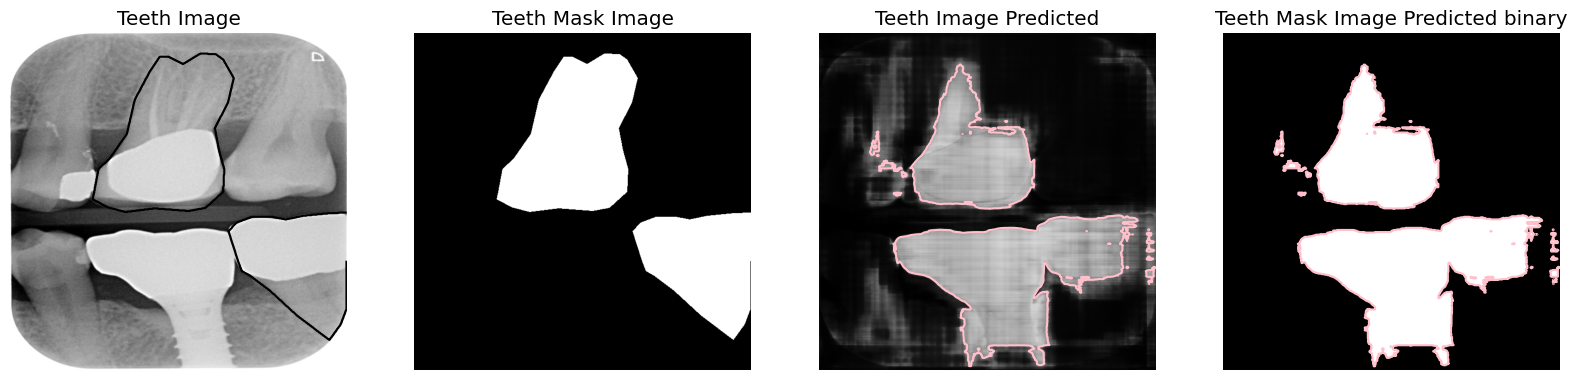

In [ ]:
# Check if training data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, idx=0)

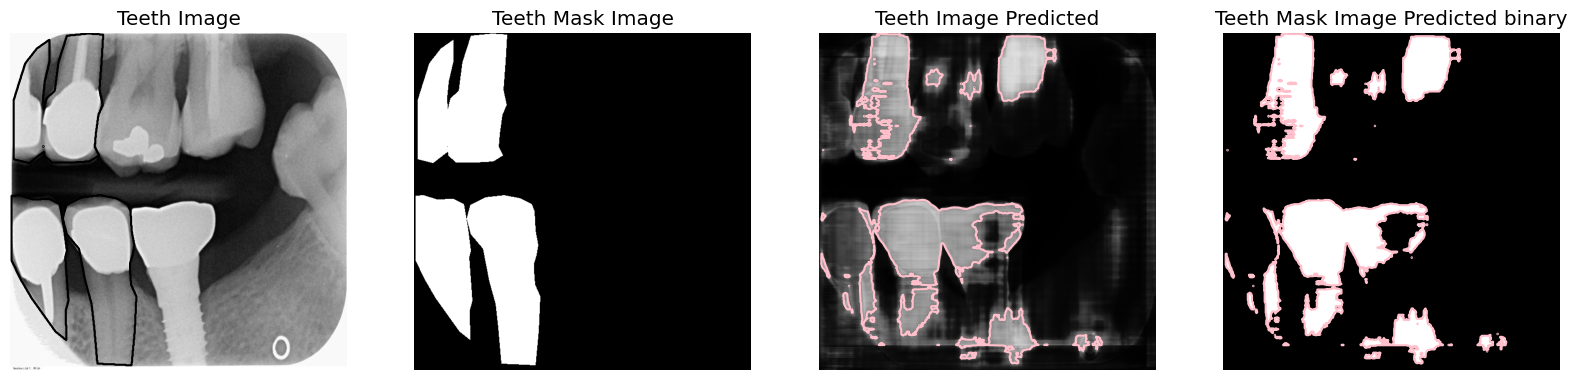

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

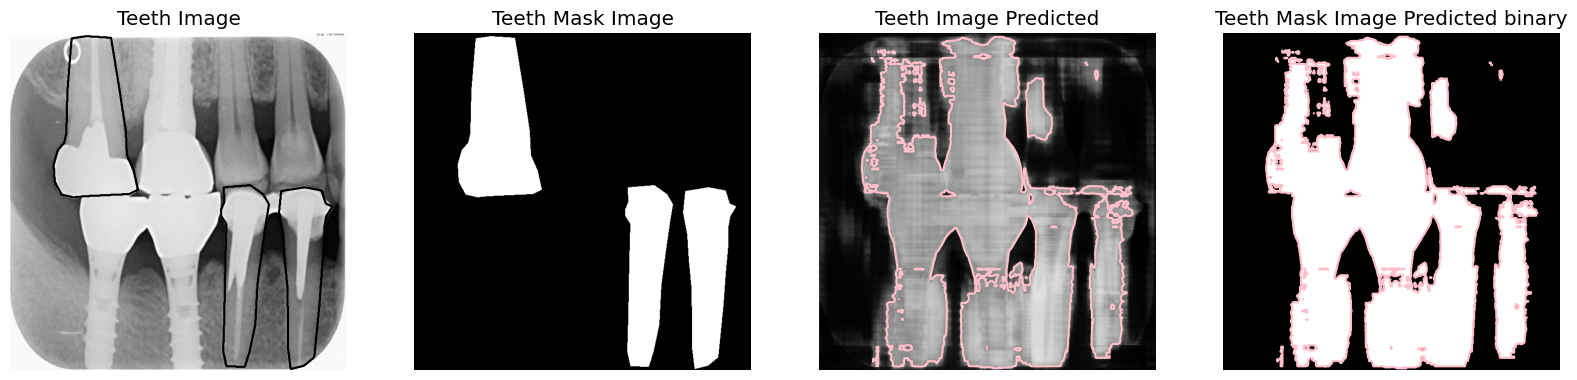

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

IndexError: index 2 is out of bounds for axis 0 with size 2

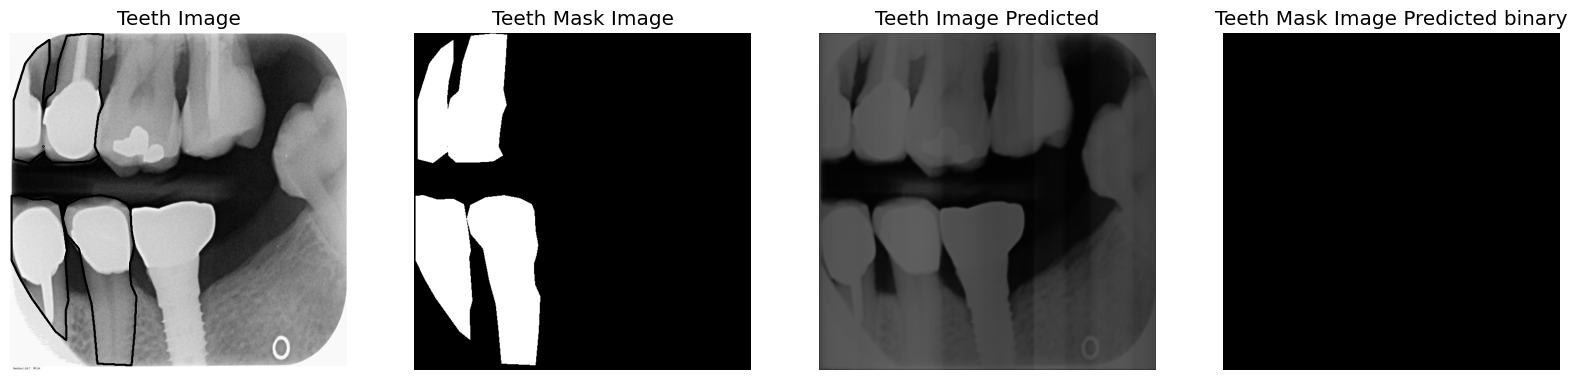

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

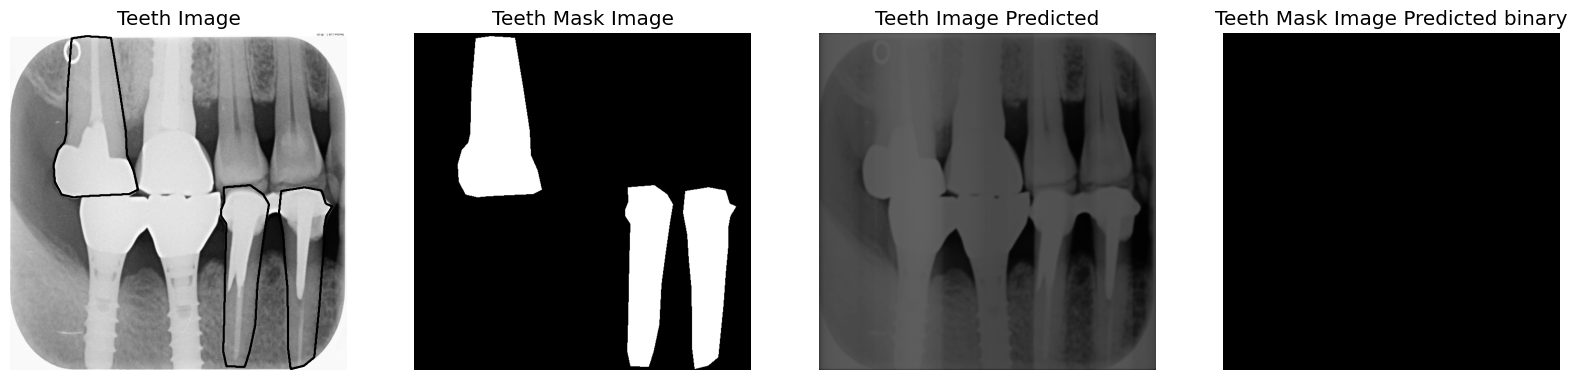

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)